# Building and Training a Small GPT Model from Scratch

This notebook provides a comprehensive, step-by-step guide to understanding, training, and using a small GPT (Generative Pre-trained Transformer) model. We'll build everything from the ground up, explaining each component along the way.

## Table of Contents
1. [Introduction](#introduction)
2. [Setup and Imports](#setup)
3. [Understanding the Architecture](#architecture)
4. [Building the Model Components](#components)
5. [Data Preparation](#data)
6. [Training the Model](#training)
7. [Text Generation (Inference)](#inference)
8. [Visualization and Analysis](#visualization)

## 1. Introduction <a name="introduction"></a>

### What is GPT?
GPT (Generative Pre-trained Transformer) is a decoder-only transformer architecture designed for language modeling. It learns to predict the next token in a sequence, which enables it to generate coherent text.

### Key Concepts:
- **Transformer Architecture**: Uses self-attention mechanisms to process sequential data
- **Causal Masking**: Ensures the model only looks at previous tokens (autoregressive)
- **Token Embeddings**: Converts discrete tokens into continuous vector representations
- **Positional Encoding**: Adds information about token positions in the sequence

### Model Architecture Overview:
```
Input Text → Tokenization → Token Embeddings + Position Embeddings
                           ↓
                    Transformer Blocks (N layers)
                    [Self-Attention + Feed Forward]
                           ↓
                    Layer Normalization
                           ↓
                    Output Projection
                           ↓
                    Predicted Next Token
```

## 2. Setup and Imports <a name="setup"></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import pickle
import os
from tqdm import tqdm

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

PyTorch Version: 2.8.0+cpu
CUDA Available: False


In [2]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    """Set random seeds for reproducibility across all libraries"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Determine device to use
def get_device():
    """Get the best available device (CUDA > MPS > CPU)"""
    if torch.cuda.is_available():
        return 'cuda'
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'

device = get_device()
print(f"Using device: {device}")

Using device: cpu


## 3. Understanding the Architecture <a name="architecture"></a>

### Architecture Components:

1. **Token + Positional Embeddings**: Convert tokens to vectors and add position information
2. **Multi-Head Self-Attention**: Allows the model to focus on different parts of the input
3. **Feed-Forward Networks**: Processes attention outputs
4. **Layer Normalization**: Stabilizes training
5. **Residual Connections**: Helps gradient flow

Let's build each component!

## 4. Building the Model Components <a name="components"></a>

### 4.1 Token Embeddings

In [3]:
class TokenEmbedding(nn.Module):
    """
    Converts token IDs to dense vectors.
    
    The scaling by sqrt(d_model) helps stabilize training.
    This is a common practice in transformer models.
    """
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        # Scale embeddings by sqrt(d_model)
        return self.embedding(x) * math.sqrt(self.d_model)

### 4.2 Positional Embeddings

Since transformers don't have inherent notion of sequence order (unlike RNNs), we need to explicitly encode position information.

In [5]:
class GPTEmbedding(nn.Module):
    """
    Combines token embeddings with learned positional embeddings.
    
    GPT uses learned positional embeddings (rather than sinusoidal),
    which can adapt better to the specific task during training.
    """
    def __init__(self, vocab_size, d_model, max_seq_len, dropout=0.1):
        super().__init__()
        self.token_embedding = TokenEmbedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_seq_len, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        seq_len = x.size(1)
        # Create position indices [0, 1, 2, ..., seq_len-1]
        pos = torch.arange(0, seq_len, dtype=torch.long, device=x.device)
        pos = pos.unsqueeze(0).expand_as(x)  # Shape: (batch_size, seq_len)
        
        # Get embeddings
        token_emb = self.token_embedding(x)
        pos_emb = self.position_embedding(pos)
        
        # Combine and apply dropout
        return self.dropout(token_emb + pos_emb)

### 4.3 Multi-Head Self-Attention

The attention mechanism is the heart of the transformer. It allows the model to focus on different parts of the input when processing each token.

In [6]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention mechanism.
    
    Key concepts:
    - Query (Q): What am I looking for?
    - Key (K): What do I contain?
    - Value (V): What information do I have?
    
    Attention(Q, K, V) = softmax(QK^T / sqrt(d_k)) V
    
    Multiple heads allow the model to attend to different aspects
    of the input simultaneously.
    """
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads  # Dimension per head

        # Linear projections for Q, K, V
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model)  # Output projection

        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)  # Scaling factor

    def forward(self, query, key, value, mask=None):
        batch_size, seq_len, d_model = query.size()

        # 1. Linear projections and reshape for multi-head attention
        # Shape: (batch_size, n_heads, seq_len, d_k)
        Q = self.w_q(query).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)

        # 2. Compute attention scores
        # Shape: (batch_size, n_heads, seq_len, seq_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale

        # 3. Apply mask (for causal attention)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # 4. Apply softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # 5. Apply attention weights to values
        context = torch.matmul(attention_weights, V)

        # 6. Concatenate heads and apply output projection
        context = context.transpose(1, 2).contiguous().view(
            batch_size, seq_len, self.d_model
        )

        output = self.w_o(context)
        return output, attention_weights

### 4.4 Causal Self-Attention

For language modeling, we need **causal** attention - the model should only attend to previous tokens, not future ones.

In [7]:
class CausalSelfAttention(nn.Module):
    """
    Causal (masked) self-attention for autoregressive language modeling.
    
    The causal mask ensures that predictions for position i can only
    depend on known outputs at positions less than i.
    
    Example mask for sequence length 4:
    [[1, 0, 0, 0],
     [1, 1, 0, 0],
     [1, 1, 1, 0],
     [1, 1, 1, 1]]
    """
    def __init__(self, d_model, n_heads, max_seq_len, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)

        # Create and register causal mask (lower triangular matrix)
        self.register_buffer(
            "causal_mask",
            torch.tril(torch.ones(max_seq_len, max_seq_len)).view(
                1, 1, max_seq_len, max_seq_len
            )
        )

    def forward(self, x):
        seq_len = x.size(1)
        # Use appropriate portion of the mask
        mask = self.causal_mask[:, :, :seq_len, :seq_len]

        output, attention_weights = self.attention(x, x, x, mask)
        return output, attention_weights

### 4.5 Feed-Forward Network

After attention, each position is processed independently through a feed-forward network.

In [8]:
class FeedForward(nn.Module):
    """
    Position-wise Feed-Forward Network.
    
    Two linear transformations with GELU activation:
    FFN(x) = GELU(xW1 + b1)W2 + b2
    
    The hidden dimension (d_ff) is typically 4x the model dimension.
    GELU (Gaussian Error Linear Unit) is smoother than ReLU.
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x -> expand -> activate -> dropout -> compress
        return self.linear2(self.dropout(F.gelu(self.linear1(x))))

### 4.6 Transformer Block

Combines attention and feed-forward with residual connections and layer normalization.

In [9]:
class TransformerBlock(nn.Module):
    """
    A single transformer block.
    
    Uses pre-norm architecture (LayerNorm before attention/FFN)
    which has been shown to train more stably than post-norm.
    
    Structure:
    x -> LayerNorm -> Attention -> + -> LayerNorm -> FFN -> + -> out
    |____________________________|   |____________________|
           (residual connection)         (residual connection)
    """
    def __init__(self, d_model, n_heads, d_ff, max_seq_len, dropout=0.1):
        super().__init__()
        self.attention = CausalSelfAttention(d_model, n_heads, max_seq_len, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention with residual connection
        attn_output, attention_weights = self.attention(self.ln1(x))
        x = x + self.dropout(attn_output)

        # Feed-forward with residual connection
        ff_output = self.feed_forward(self.ln2(x))
        x = x + self.dropout(ff_output)

        return x, attention_weights

### 4.7 Complete GPT Model

Now we assemble all components into the complete GPT model.

In [10]:
class SmallGPT(nn.Module):
    """
    A small GPT model for language modeling.
    
    Architecture:
    1. Token + Position embeddings
    2. Stack of N transformer blocks
    3. Final layer norm
    4. Output projection to vocabulary
    
    The model uses weight tying: the output projection shares
    weights with the input embeddings, reducing parameters.
    """
    def __init__(
        self,
        vocab_size=50257,
        d_model=384,
        n_heads=6,
        n_layers=6,
        d_ff=1536,
        max_seq_len=1024,
        dropout=0.1,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.max_seq_len = max_seq_len

        # Embeddings
        self.embedding = GPTEmbedding(vocab_size, d_model, max_seq_len, dropout)

        # Stack of transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff, max_seq_len, dropout)
            for _ in range(n_layers)
        ])

        # Final layer norm and output projection
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

        # Weight tying: share weights between input and output embeddings
        self.head.weight = self.embedding.token_embedding.embedding.weight

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """Initialize weights with small random values"""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def forward(self, idx, targets=None):
        """
        Forward pass through the model.
        
        Args:
            idx: Input token indices (batch_size, seq_len)
            targets: Target token indices for training (batch_size, seq_len)
        
        Returns:
            logits: Predicted logits (batch_size, seq_len, vocab_size)
            loss: Cross-entropy loss (if targets provided)
        """
        b, t = idx.size()
        assert t <= self.max_seq_len, f"Sequence length {t} exceeds maximum {self.max_seq_len}"

        # 1. Embed tokens
        x = self.embedding(idx)

        # 2. Process through transformer blocks
        attention_weights = []
        for block in self.transformer_blocks:
            x, attn_weights = block(x)
            attention_weights.append(attn_weights)

        # 3. Final layer norm and projection to vocabulary
        x = self.ln_f(x)
        logits = self.head(x)

        # 4. Compute loss if targets provided
        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)), 
                targets.view(-1), 
                ignore_index=-1
            )
            return logits, loss

        return logits

    def get_num_params(self):
        """Count the number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate new tokens autoregressively.
        
        Args:
            idx: Starting token indices (batch_size, seq_len)
            max_new_tokens: Number of tokens to generate
            temperature: Sampling temperature (higher = more random)
            top_k: If set, only sample from top k tokens
        
        Returns:
            Generated token indices (batch_size, seq_len + max_new_tokens)
        """
        self.eval()
        for _ in range(max_new_tokens):
            # Crop context if needed
            idx_cond = idx if idx.size(1) <= self.max_seq_len else idx[:, -self.max_seq_len:]

            # Forward pass
            logits = self(idx_cond)

            # Get logits for last position and apply temperature
            logits = logits[:, -1, :] / temperature

            # Optional top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')

            # Convert to probabilities and sample
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)

            # Append to sequence
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [11]:
def create_small_gpt(config=None):
    """
    Factory function to create a small GPT model with default or custom config.
    """
    if config is None:
        config = {
            'vocab_size': 100,  # Small vocab for tutorial
            'd_model': 128,     # Model dimension
            'n_heads': 4,       # Number of attention heads
            'n_layers': 4,      # Number of transformer layers
            'd_ff': 512,        # Feed-forward dimension
            'max_seq_len': 256, # Maximum sequence length
            'dropout': 0.1,     # Dropout rate
        }
    return SmallGPT(**config)

# Create a test model to verify it works
test_model = create_small_gpt()
print(f"Model created successfully!")
print(f"Number of parameters: {test_model.get_num_params():,}")
print(f"Model size: {test_model.get_num_params() * 4 / 1024 / 1024:.2f} MB (float32)")

Model created successfully!
Number of parameters: 837,376
Model size: 3.19 MB (float32)


## 5. Data Preparation <a name="data"></a>

### 5.1 Simple Character-Level Tokenizer

For simplicity, we'll use character-level tokenization (each character is a token).

In [12]:
class SimpleTokenizer:
    """
    Simple character-level tokenizer.
    
    Converts text to a sequence of integers (token IDs) and vice versa.
    Each unique character gets a unique ID.
    """
    def __init__(self):
        self.vocab = {}
        self.inverse_vocab = {}
        self.vocab_size = 0
        self.unk_token = '<UNK>'

    def build_vocab(self, text):
        """Build vocabulary from text"""
        chars = sorted(list(set(text)))
        # Add unknown token
        chars = [self.unk_token] + chars
        self.vocab_size = len(chars)
        self.vocab = {ch: i for i, ch in enumerate(chars)}
        self.inverse_vocab = {i: ch for i, ch in enumerate(chars)}
        print(f"Vocabulary size: {self.vocab_size}")
        print(f"Sample tokens: {list(self.vocab.items())[:10]}")

    def encode(self, text):
        """Convert text to token IDs"""
        return [self.vocab.get(c, self.vocab[self.unk_token]) for c in text]

    def decode(self, tokens):
        """Convert token IDs back to text"""
        return ''.join([self.inverse_vocab[t] for t in tokens])

    def save(self, path):
        """Save tokenizer to disk"""
        with open(path, 'wb') as f:
            pickle.dump({
                'vocab': self.vocab,
                'inverse_vocab': self.inverse_vocab,
                'vocab_size': self.vocab_size
            }, f)

    def load(self, path):
        """Load tokenizer from disk"""
        with open(path, 'rb') as f:
            data = pickle.load(f)
            self.vocab = data['vocab']
            self.inverse_vocab = data['inverse_vocab']
            self.vocab_size = data['vocab_size']

### 5.2 Dataset Class

In [13]:
class TextDataset(Dataset):
    """
    PyTorch Dataset for language modeling.
    
    Creates (input, target) pairs where target is input shifted by one position.
    For example:
        Input:  "hello worl"
        Target: "ello world"
    
    This trains the model to predict the next character.
    """
    def __init__(self, data, block_size):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # Get a chunk of data
        chunk = self.data[idx:idx + self.block_size + 1]
        
        # Convert to numpy array if needed
        if isinstance(chunk, list):
            chunk = np.array(chunk, dtype=np.int64)
        
        # Input is chunk[:-1], target is chunk[1:]
        x = torch.from_numpy((chunk[:-1]).astype(np.int64))
        y = torch.from_numpy((chunk[1:]).astype(np.int64))
        return x, y

### 5.3 Prepare Sample Data

Let's create some sample text for training.

In [14]:
# Create sample training data
sample_text = """
The journey of a thousand miles begins with a single step.
To be or not to be, that is the question.
In the beginning was the Word, and the Word was with God.
All that glitters is not gold.
The only thing we have to fear is fear itself.
Ask not what your country can do for you, ask what you can do for your country.
I think, therefore I am.
The unexamined life is not worth living.
Knowledge is power.
To infinity and beyond!
May the Force be with you.
Life is like a box of chocolates.
Houston, we have a problem.
Elementary, my dear Watson.
Frankly, my dear, I don't give a damn.
""" * 10  # Repeat for more training data

print(f"Text length: {len(sample_text)} characters")
print(f"\nFirst 200 characters:\n{sample_text[:200]}")

Text length: 5840 characters

First 200 characters:

The journey of a thousand miles begins with a single step.
To be or not to be, that is the question.
In the beginning was the Word, and the Word was with God.
All that glitters is not gold.
The only 


In [15]:
# Initialize tokenizer and build vocabulary
tokenizer = SimpleTokenizer()
tokenizer.build_vocab(sample_text)

# Encode the text
encoded_data = np.array(tokenizer.encode(sample_text), dtype=np.int64)
print(f"\nEncoded data shape: {encoded_data.shape}")
print(f"Sample encoded data: {encoded_data[:50]}")

Vocabulary size: 43
Sample tokens: [('<UNK>', 0), ('\n', 1), (' ', 2), ('!', 3), ("'", 4), (',', 5), ('.', 6), ('A', 7), ('E', 8), ('F', 9)]

Encoded data shape: (5840,)
Sample encoded data: [ 1 16 25 22  2 27 32 38 35 31 22 42  2 32 23  2 18  2 37 25 32 38 36 18
 31 21  2 30 26 29 22 36  2 19 22 24 26 31 36  2 40 26 37 25  2 18  2 36
 26 31]


In [16]:
# Split into train and validation sets
train_split = 0.9
n = int(train_split * len(encoded_data))
train_data = encoded_data[:n]
val_data = encoded_data[n:]

print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")

Train data size: 5256
Validation data size: 584


In [17]:
# Create datasets and dataloaders
block_size = 64  # Context length
batch_size = 16

train_dataset = TextDataset(train_data, block_size)
val_dataset = TextDataset(val_data, block_size)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

# Show a sample batch
sample_x, sample_y = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"  Input (x): {sample_x.shape}")
print(f"  Target (y): {sample_y.shape}")
print(f"\nSample input sequence:")
print(f"  Tokens: {sample_x[0][:20].tolist()}")
print(f"  Text: '{tokenizer.decode(sample_x[0][:20].tolist())}'")
print(f"\nSample target sequence:")
print(f"  Tokens: {sample_y[0][:20].tolist()}")
print(f"  Text: '{tokenizer.decode(sample_y[0][:20].tolist())}'")

Number of training batches: 325
Number of validation batches: 33

Sample batch shapes:
  Input (x): torch.Size([16, 64])
  Target (y): torch.Size([16, 64])

Sample input sequence:
  Tokens: [42, 6, 1, 12, 2, 37, 25, 26, 31, 28, 5, 2, 37, 25, 22, 35, 22, 23, 32, 35]
  Text: 'y.
I think, therefor'

Sample target sequence:
  Tokens: [6, 1, 12, 2, 37, 25, 26, 31, 28, 5, 2, 37, 25, 22, 35, 22, 23, 32, 35, 22]
  Text: '.
I think, therefore'


c:\Users\Niket Sharma\llmapp\LLMs-from-groundup\llmgenv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


## 6. Training the Model <a name="training"></a>

### 6.1 Training Configuration

In [18]:
# Model configuration
config = {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 128,        # Embedding dimension
    'n_heads': 4,          # Number of attention heads
    'n_layers': 4,         # Number of transformer layers
    'd_ff': 512,           # Feed-forward hidden dimension
    'max_seq_len': 256,    # Maximum sequence length
    'dropout': 0.1,        # Dropout rate
}

# Training configuration
learning_rate = 3e-4
weight_decay = 0.1
epochs = 20

print("Model Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")
print(f"\nTraining Configuration:")
print(f"  Learning rate: {learning_rate}")
print(f"  Weight decay: {weight_decay}")
print(f"  Epochs: {epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Block size: {block_size}")

Model Configuration:
  vocab_size: 43
  d_model: 128
  n_heads: 4
  n_layers: 4
  d_ff: 512
  max_seq_len: 256
  dropout: 0.1

Training Configuration:
  Learning rate: 0.0003
  Weight decay: 0.1
  Epochs: 20
  Batch size: 16
  Block size: 64


In [19]:
# Create the model
model = create_small_gpt(config)
model = model.to(device)

print(f"Model created and moved to {device}")
print(f"Number of parameters: {model.get_num_params():,}")
print(f"Model size: {model.get_num_params() * 4 / 1024 / 1024:.2f} MB")

Model created and moved to cpu
Number of parameters: 830,080
Model size: 3.17 MB


### 6.2 Training Loop

Now let's implement the training loop with proper optimization and learning rate scheduling.

In [20]:
class GPTTrainer:
    """
    Trainer class for GPT model.
    
    Handles:
    - Training loop with gradient clipping
    - Validation
    - Learning rate scheduling (cosine annealing)
    - Checkpointing
    - Loss tracking
    """
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        lr=3e-4,
        weight_decay=0.1,
        betas=(0.9, 0.95),
        device='cuda' if torch.cuda.is_available() else 'cpu'
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        # AdamW optimizer (Adam with weight decay)
        self.optimizer = AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            betas=betas
        )

        # Cosine annealing learning rate scheduler
        self.scheduler = CosineAnnealingLR(
            self.optimizer,
            T_max=len(train_loader) * 10,
            eta_min=lr * 0.1
        )

        self.best_val_loss = float('inf')
        self.train_losses = []
        self.val_losses = []

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        num_batches = 0

        pbar = tqdm(self.train_loader, desc="Training")
        for batch_idx, (data, targets) in enumerate(pbar):
            data, targets = data.to(self.device), targets.to(self.device)

            # Zero gradients
            self.optimizer.zero_grad()

            # Forward pass
            logits, loss = self.model(data, targets)

            # Backward pass
            loss.backward()

            # Gradient clipping (prevents exploding gradients)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

            # Update weights
            self.optimizer.step()
            self.scheduler.step()

            total_loss += loss.item()
            num_batches += 1

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'avg_loss': f'{total_loss/num_batches:.4f}',
                'lr': f'{self.scheduler.get_last_lr()[0]:.2e}'
            })

        return total_loss / num_batches

    @torch.no_grad()
    def validate(self):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        num_batches = 0

        for data, targets in tqdm(self.val_loader, desc="Validation"):
            data, targets = data.to(self.device), targets.to(self.device)
            logits, loss = self.model(data, targets)
            total_loss += loss.item()
            num_batches += 1

        return total_loss / num_batches

    def train(self, epochs):
        """Train for multiple epochs"""
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            print("-" * 50)

            # Train
            train_loss = self.train_epoch()
            self.train_losses.append(train_loss)

            # Validate
            val_loss = self.validate()
            self.val_losses.append(val_loss)

            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

            # Update best validation loss
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                print(f"New best validation loss: {val_loss:.4f}")

        return self.train_losses, self.val_losses

In [21]:
# Create trainer
trainer = GPTTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=learning_rate,
    weight_decay=weight_decay,
    device=device
)

print("Trainer created. Ready to start training!")

Trainer created. Ready to start training!


In [22]:
# Train the model
print("Starting training...\n")
train_losses, val_losses = trainer.train(epochs=epochs)
print("\nTraining completed!")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")
print(f"Best validation loss: {trainer.best_val_loss:.4f}")

Starting training...


Epoch 1/20
--------------------------------------------------


Training:   0%|          | 0/325 [00:00<?, ?it/s]c:\Users\Niket Sharma\llmapp\LLMs-from-groundup\llmgenv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validation: 100%|██████████| 33/33 [00:00<00:00, 33.16it/s]


Train Loss: 1.9261 | Val Loss: 1.0748
New best validation loss: 1.0748

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:00<00:00, 35.61it/s]


Train Loss: 0.9369 | Val Loss: 0.4655
New best validation loss: 0.4655

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:01<00:00, 31.74it/s]


Train Loss: 0.5501 | Val Loss: 0.2321
New best validation loss: 0.2321

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:01<00:00, 27.44it/s]


Train Loss: 0.3533 | Val Loss: 0.1405
New best validation loss: 0.1405

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:01<00:00, 25.39it/s]


Train Loss: 0.2459 | Val Loss: 0.1041
New best validation loss: 0.1041

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:01<00:00, 23.94it/s]


Train Loss: 0.1887 | Val Loss: 0.0843
New best validation loss: 0.0843

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:01<00:00, 27.39it/s]


Train Loss: 0.1576 | Val Loss: 0.0776
New best validation loss: 0.0776

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:01<00:00, 28.48it/s]


Train Loss: 0.1415 | Val Loss: 0.0721
New best validation loss: 0.0721

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:01<00:00, 27.83it/s]


Train Loss: 0.1317 | Val Loss: 0.0701
New best validation loss: 0.0701

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:01<00:00, 27.07it/s]


Train Loss: 0.1251 | Val Loss: 0.0689
New best validation loss: 0.0689

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:01<00:00, 29.43it/s]


Train Loss: 0.1224 | Val Loss: 0.0678
New best validation loss: 0.0678

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:01<00:00, 30.57it/s]


Train Loss: 0.1201 | Val Loss: 0.0665
New best validation loss: 0.0665

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:01<00:00, 32.85it/s]


Train Loss: 0.1164 | Val Loss: 0.0654
New best validation loss: 0.0654

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:01<00:00, 31.77it/s]


Train Loss: 0.1133 | Val Loss: 0.0675

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:00<00:00, 34.69it/s]


Train Loss: 0.1084 | Val Loss: 0.0636
New best validation loss: 0.0636

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:00<00:00, 33.53it/s]


Train Loss: 0.1037 | Val Loss: 0.0627
New best validation loss: 0.0627

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:01<00:00, 30.19it/s]


Train Loss: 0.1001 | Val Loss: 0.0643

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:01<00:00, 31.94it/s]


Train Loss: 0.0950 | Val Loss: 0.0637

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:00<00:00, 38.72it/s]


Train Loss: 0.0905 | Val Loss: 0.0623
New best validation loss: 0.0623

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 33/33 [00:00<00:00, 39.33it/s]

Train Loss: 0.0865 | Val Loss: 0.0618
New best validation loss: 0.0618

Training completed!
Final train loss: 0.0865
Final validation loss: 0.0618
Best validation loss: 0.0618


### 6.3 Visualize Training Progress

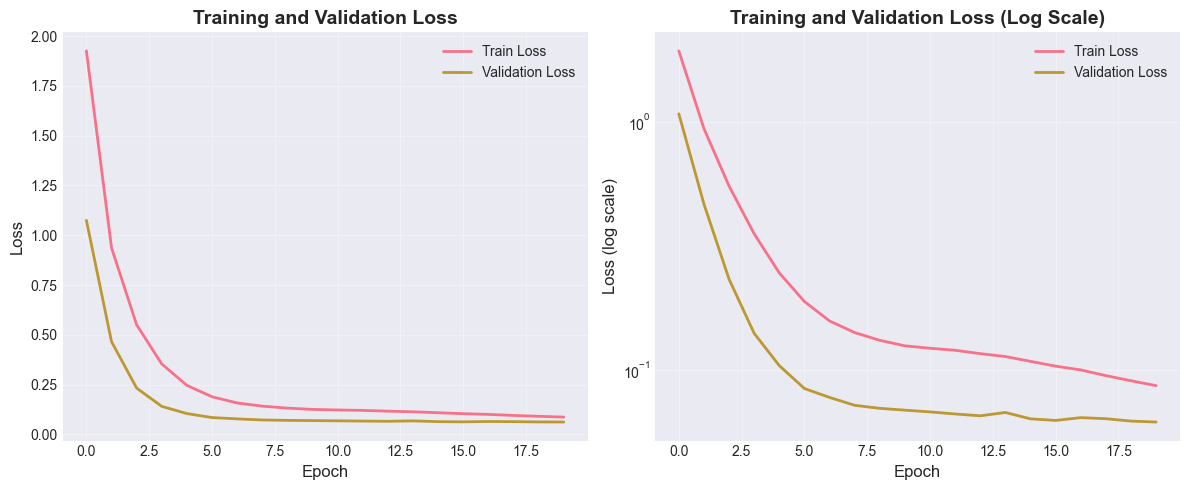


Training loss improved by 95.51%
Validation loss improved by 94.25%


In [23]:
# Plot training and validation losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (log scale)', fontsize=12)
plt.title('Training and Validation Loss (Log Scale)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print improvement statistics
train_improvement = (train_losses[0] - train_losses[-1]) / train_losses[0] * 100
val_improvement = (val_losses[0] - val_losses[-1]) / val_losses[0] * 100
print(f"\nTraining loss improved by {train_improvement:.2f}%")
print(f"Validation loss improved by {val_improvement:.2f}%")

## 7. Text Generation (Inference) <a name="inference"></a>

Now let's use our trained model to generate text!

In [24]:
def generate_text(model, tokenizer, prompt, max_new_tokens=100, temperature=1.0, top_k=None, device='cpu'):
    """
    Generate text from a prompt.
    
    Args:
        model: Trained GPT model
        tokenizer: Tokenizer for encoding/decoding
        prompt: Starting text
        max_new_tokens: Number of tokens to generate
        temperature: Sampling temperature (higher = more random)
        top_k: If set, only sample from top k most likely tokens
        device: Device to run on
    
    Returns:
        Generated text
    """
    model.eval()
    
    # Encode the prompt
    context = torch.tensor(tokenizer.encode(prompt), dtype=torch.long, device=device)
    context = context.unsqueeze(0)  # Add batch dimension
    
    # Generate
    with torch.no_grad():
        generated = model.generate(
            context, 
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_k=top_k
        )
    
    # Decode and return
    generated_text = tokenizer.decode(generated[0].tolist())
    return generated_text

In [25]:
# Test generation with different prompts
prompts = [
    "The journey",
    "To be or",
    "Knowledge is",
    "May the Force",
]

print("=" * 80)
print("TEXT GENERATION EXAMPLES")
print("=" * 80)

for prompt in prompts:
    print(f"\n{'='*80}")
    print(f"Prompt: '{prompt}'")
    print(f"{'-'*80}")
    
    generated = generate_text(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        max_new_tokens=100,
        temperature=0.8,
        top_k=40,
        device=device
    )
    
    print(f"Generated: '{generated}'")
    print(f"{'='*80}")

TEXT GENERATION EXAMPLES

Prompt: 'The journey'
--------------------------------------------------------------------------------
Generated: 'The journey of a thousand miles begins with a single step.
To be or or not to to to be, that t t t tha is t the'

Prompt: 'To be or'
--------------------------------------------------------------------------------
Generated: 'To be or not to be, that is the question.
In the beginning was the the Word, Word Word and the wand the the '

Prompt: 'Knowledge is'
--------------------------------------------------------------------------------
Generated: 'Knowledge is power.
To infinity and beyond!
May the Force be with you.
Life you.
Lis you.
Like ay cay ce ce cayo'

Prompt: 'May the Force'
--------------------------------------------------------------------------------
Generated: 'May the Force be with you.
Life is like a box of chocolates.
Houston, we have ave bla problem.
Elemestoblen.
Elem'


### 7.1 Exploring Different Sampling Strategies

Let's compare different temperature and top-k settings.

In [26]:
# Compare different temperature settings
prompt = "The journey"
temperatures = [0.5, 0.8, 1.0, 1.2]

print("=" * 80)
print("TEMPERATURE COMPARISON")
print("=" * 80)
print("Lower temperature = more conservative/repetitive")
print("Higher temperature = more creative/random\n")

for temp in temperatures:
    generated = generate_text(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        max_new_tokens=80,
        temperature=temp,
        top_k=40,
        device=device
    )
    print(f"\nTemperature = {temp}:")
    print(f"{'-'*80}")
    print(generated)
    print(f"{'-'*80}")

TEMPERATURE COMPARISON
Lower temperature = more conservative/repetitive
Higher temperature = more creative/random


Temperature = 0.5:
--------------------------------------------------------------------------------
The journey of a thousand miles begins with a single step.
To be or not to to to be be, tha
--------------------------------------------------------------------------------

Temperature = 0.8:
--------------------------------------------------------------------------------
The journey of a thousand miles begins with a single step.
To be or not to to to be, tha t 
--------------------------------------------------------------------------------

Temperature = 1.0:
--------------------------------------------------------------------------------
The journey of a thousand miles begins with a single step.
To be or not to to be to be, tha
--------------------------------------------------------------------------------

Temperature = 1.2:
-------------------------------------------

## 8. Visualization and Analysis <a name="visualization"></a>

### 8.1 Visualize Attention Patterns

Let's look at what the model is paying attention to.

In [27]:
def get_attention_weights(model, text, tokenizer, device='cpu'):
    """
    Get attention weights for a given text.
    
    Returns attention weights from all layers and heads.
    """
    model.eval()
    
    # Encode text
    tokens = torch.tensor(tokenizer.encode(text), dtype=torch.long, device=device)
    tokens = tokens.unsqueeze(0)  # Add batch dimension
    
    # Forward pass
    with torch.no_grad():
        x = model.embedding(tokens)
        attention_weights = []
        
        for block in model.transformer_blocks:
            x, attn = block(x)
            attention_weights.append(attn)
    
    return attention_weights, text

def plot_attention(attention_weights, text, layer_idx=0, head_idx=0):
    """
    Plot attention weights as a heatmap.
    """
    # Get attention for specific layer and head
    attn = attention_weights[layer_idx][0, head_idx].cpu().numpy()
    
    # Create figure
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        attn,
        xticklabels=list(text),
        yticklabels=list(text),
        cmap='viridis',
        cbar_kws={'label': 'Attention Weight'},
        square=True
    )
    plt.xlabel('Key Position', fontsize=12)
    plt.ylabel('Query Position', fontsize=12)
    plt.title(
        f'Attention Weights - Layer {layer_idx + 1}, Head {head_idx + 1}',
        fontsize=14,
        fontweight='bold'
    )
    plt.tight_layout()
    plt.show()

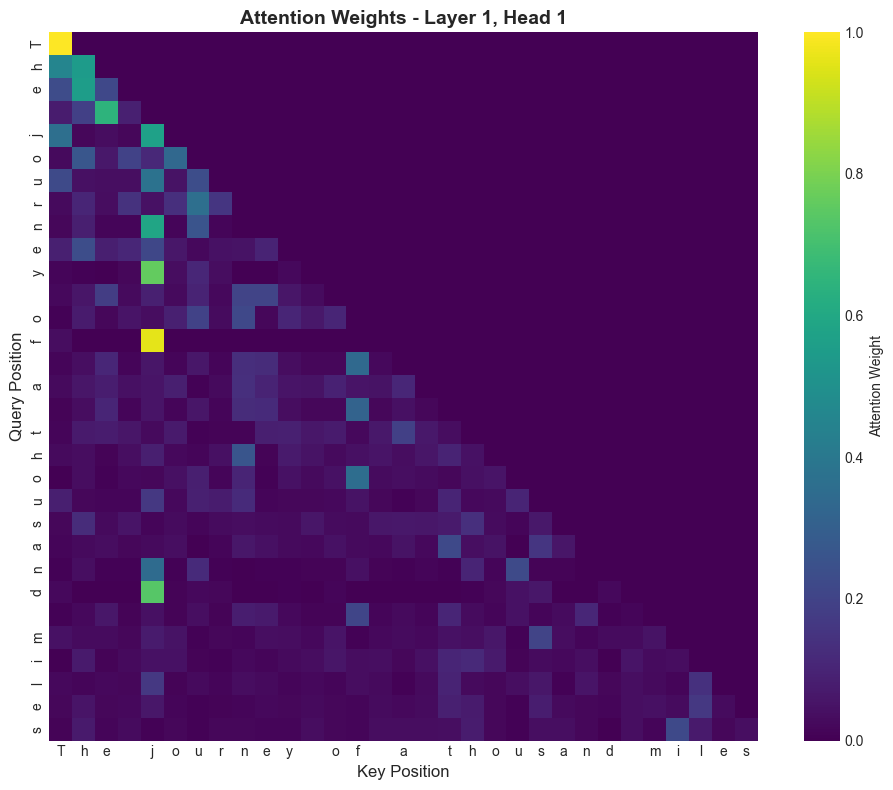

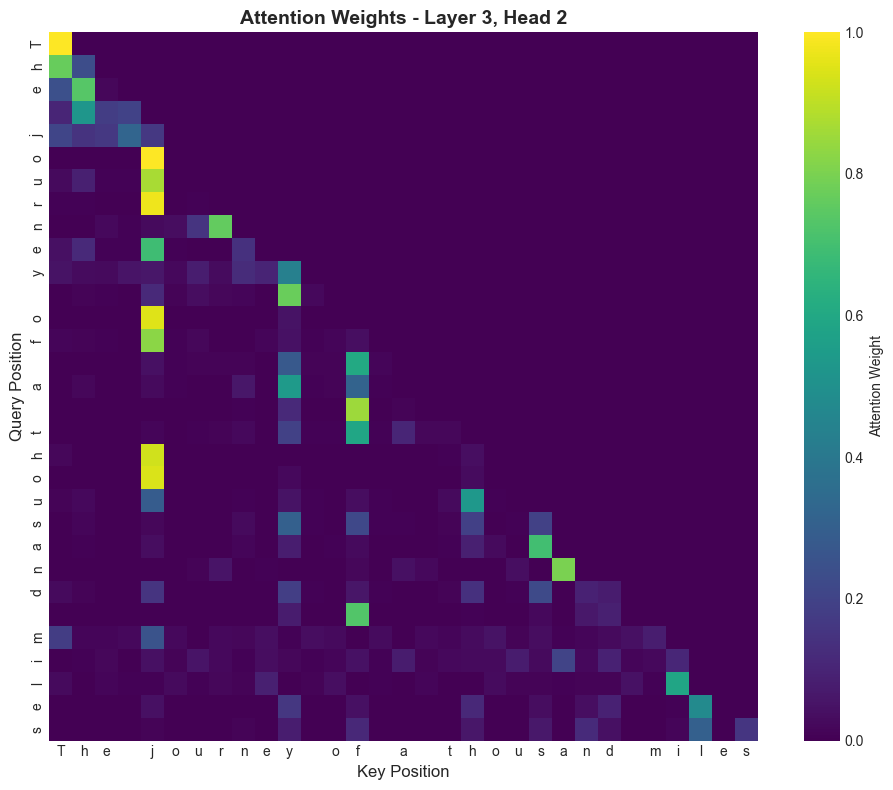

In [28]:
# Visualize attention for a sample text
sample_text = "The journey of a thousand miles"
attention_weights, text = get_attention_weights(model, sample_text, tokenizer, device)

# Plot attention from different layers and heads
plot_attention(attention_weights, text, layer_idx=0, head_idx=0)
plot_attention(attention_weights, text, layer_idx=2, head_idx=1)

### 8.2 Model Statistics

In [29]:
# Print detailed model statistics
def analyze_model(model):
    """
    Print detailed statistics about the model.
    """
    print("=" * 80)
    print("MODEL ANALYSIS")
    print("=" * 80)
    
    # Overall statistics
    total_params = model.get_num_params()
    print(f"\nTotal Parameters: {total_params:,}")
    print(f"Model Size: {total_params * 4 / 1024 / 1024:.2f} MB (float32)")
    
    # Parameters by component
    print("\nParameters by Component:")
    print("-" * 80)
    
    for name, module in model.named_children():
        num_params = sum(p.numel() for p in module.parameters())
        print(f"  {name:30s}: {num_params:>12,} ({num_params/total_params*100:>5.2f}%)")
    
    # Configuration
    print("\nConfiguration:")
    print("-" * 80)
    print(f"  Vocabulary size: {model.vocab_size}")
    print(f"  Model dimension: {model.d_model}")
    print(f"  Number of heads: {model.n_heads}")
    print(f"  Number of layers: {model.n_layers}")
    print(f"  Max sequence length: {model.max_seq_len}")
    
    print("\n" + "=" * 80)

analyze_model(model)

MODEL ANALYSIS

Total Parameters: 830,080
Model Size: 3.17 MB (float32)

Parameters by Component:
--------------------------------------------------------------------------------
  embedding                     :       38,272 ( 4.61%)
  transformer_blocks            :      791,552 (95.36%)
  ln_f                          :          256 ( 0.03%)
  head                          :        5,504 ( 0.66%)

Configuration:
--------------------------------------------------------------------------------
  Vocabulary size: 43
  Model dimension: 128
  Number of heads: 4
  Number of layers: 4
  Max sequence length: 256



### 8.3 Save the Model

In [30]:
# Create directory for saving
os.makedirs('saved_models', exist_ok=True)

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'config': config,
    'train_losses': train_losses,
    'val_losses': val_losses,
}, 'saved_models/gpt_model.pt')

# Save tokenizer
tokenizer.save('saved_models/tokenizer.pkl')

print("Model saved successfully!")
print("  Model: saved_models/gpt_model.pt")
print("  Tokenizer: saved_models/tokenizer.pkl")

Model saved successfully!
  Model: saved_models/gpt_model.pt
  Tokenizer: saved_models/tokenizer.pkl


### 8.4 Load and Use Saved Model

In [31]:
# Example: Load the saved model
def load_model(model_path, tokenizer_path, device='cpu'):
    """
    Load a saved model and tokenizer.
    """
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Create model with saved config
    model = create_small_gpt(checkpoint['config'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    # Load tokenizer
    tokenizer = SimpleTokenizer()
    tokenizer.load(tokenizer_path)
    
    return model, tokenizer, checkpoint

# Load the model
loaded_model, loaded_tokenizer, checkpoint = load_model(
    'saved_models/gpt_model.pt',
    'saved_models/tokenizer.pkl',
    device=device
)

print("Model loaded successfully!")

# Test with the loaded model
test_prompt = "Knowledge is"
generated = generate_text(
    loaded_model,
    loaded_tokenizer,
    test_prompt,
    max_new_tokens=50,
    temperature=0.8,
    device=device
)

print(f"\nTest generation with loaded model:")
print(f"Prompt: '{test_prompt}'")
print(f"Generated: '{generated}'")

Model loaded successfully!

Test generation with loaded model:
Prompt: 'Knowledge is'
Generated: 'Knowledge is power.
To infinity and beyond!
May the Force be w'


## Summary

Congratulations! You've successfully:

1. **Built a GPT model from scratch** with all components:
   - Token and positional embeddings
   - Multi-head self-attention
   - Causal masking for autoregressive generation
   - Feed-forward networks
   - Layer normalization and residual connections

2. **Prepared data** for training:
   - Created a simple character-level tokenizer
   - Built a dataset with proper train/val splits
   - Created PyTorch DataLoaders

3. **Trained the model**:
   - Implemented a complete training loop
   - Used AdamW optimizer with gradient clipping
   - Applied cosine annealing learning rate schedule
   - Monitored training and validation losses

4. **Generated text**:
   - Implemented autoregressive text generation
   - Explored different sampling strategies (temperature, top-k)

5. **Analyzed the model**:
   - Visualized attention patterns
   - Examined model statistics
   - Saved and loaded models

### Next Steps:

To improve the model further, you could:
- Train on larger datasets (e.g., books, Wikipedia)
- Use byte-pair encoding (BPE) tokenization instead of character-level
- Increase model size (more layers, larger dimensions)
- Add techniques like dropout, weight tying variations
- Implement more advanced sampling strategies (nucleus sampling)
- Fine-tune on specific tasks

### References:
- [Attention Is All You Need](https://arxiv.org/abs/1706.03762) - Original Transformer paper
- [GPT-2 Paper](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
- [The Illustrated GPT-2](https://jalammar.github.io/illustrated-gpt2/)
- [Andrej Karpathy's minGPT](https://github.com/karpathy/minGPT)